# load_ext

In [1]:
%load_ext magic_markdown
%load_ext sql
%load_ext jupyter_spaces
%load_ext blackcellmagic
%load_ext watermark
%load_ext heat


# import 

In [2]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
import lsqfit
import gvar as gv

# read data

In [3]:
# import pandas as pd
# df = pd.DataFrame(columns=['data_name', 'data_num', 'data_real', 'data_imag'])
# for i in range(50):
#     file_name = f'corr_uu_gammai_Px0Py0Pz0_conf{i*50+15000}.dat'
#     with open(file_name, 'r') as file:
#         lines = file.readlines()[1:]
#         for line in lines:
#             data = line.split()
#             df_ = pd.DataFrame(
#                 {'data_name': [i*50+15000],
#                  'data_num': [data[0]],
#                  'data_real': [data[1]],
#                  'data_imag': [data[2]]})
#             df = df.append(df_)
# df.to_excel('corr_uu_gammai_Px0Py0Pz0_conf15000-17450.xlsx', index=False)


# data preprocessing

In [4]:
# def merge_adjacent(arr, n):
#     # 合并相邻的相同元素
#     merged_arr = []
#     i = 0
#     while i < len(arr):
#         j = i + 1
#         while j < len(arr) and arr[j] == arr[i]:
#             j += 1
#         merged_arr.append(arr[i])
#         i = j
#     # 重复元素 n 次
#     repeated_arr = []
#     for elem in merged_arr:
#         repeated_arr.extend([elem] * n)
#     return repeated_arr
# # 打开文件，按行读取内容，并将每行内容添加到一个数组中
# with open("ztest.txt", "r") as file:
#     lines = file.readlines()
#     lines = [line.strip() for line in lines]

# # 输出读取到的内容数组
# print(lines)

# # 示例代码
# arr = lines
# print(merge_adjacent(arr, 64))
# arr=merge_adjacent(arr, 64)
# # 打开文件，写入数组中的每个元素，并在每个元素后添加一个换行符
# with open("output.txt", "w") as file:
#     for line in arr:
#         file.write(line + "\n")


In [5]:
def read_xlsx(file_path):
    df = pd.read_excel(file_path)
    return df


file_path = "corr_uu_gamma5_Px0Py0Pz0_conf15000-17450.xlsx"
df = read_xlsx(file_path)
df.info()

# df=df.astype("Float32")
# df['data_name']=df['data_name'].astype('int')
# df['data_num']=df['data_num'].astype('int')
df_list = [df.iloc[i*len(df['data_num'].unique()):(i+1)*len(df['data_num'].unique())]
           for i in range(len(df['data_name'].unique()))]

for i in range(len(df_list)):
    df_list[i] = df_list[i].reset_index(drop=True)
    df0 = df_list[i][(df['data_num'] >= 1) & (
        df['data_num'] <= 32)].reset_index(drop=True)
    df1 = df_list[i][(df['data_num'] >= 32) & (
        df['data_num'] <= 63)][::-1].reset_index(drop=True)
    df0['data_real'] = (df0['data_real']+df1['data_real'])/2
    df0['data_imag'] = (df0['data_imag']+df1['data_imag'])/2
    df_list[i] = df0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   data_name  3200 non-null   int64  
 1   data_num   3200 non-null   int64  
 2   data_real  3200 non-null   float64
 3   data_imag  3200 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 100.1 KB


/tmp/ipykernel_82675/3188047772.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df0 = df_list[i][(df['data_num'] >= 1) & (
/tmp/ipykernel_82675/3188047772.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_list[i][(df['data_num'] >= 32) & (


# jackknife

In [6]:
def jackknife(arr):
    arr = np.array(arr)
    n = len(arr)
    jk_mean = (np.sum(arr) - arr) / (n - 1)
    return pd.DataFrame({'mean': jk_mean, 'std': [np.sqrt((n - 1))*np.std(jk_mean)]*n})


arr = np.array([1, 2, 3, 4, 5])
# arr = df["data_real"][0:64]
# print(arr)
jk_all = jackknife(arr)
print("Jackknife mean:\n", jk_all['mean'])
print("Jackknife std:\n", jk_all['std'])
print("no-Jackknife std:\n", np.std(arr))


Jackknife mean:
 0    3.50
1    3.25
2    3.00
3    2.75
4    2.50
Name: mean, dtype: float64
Jackknife std:
 0    0.707107
1    0.707107
2    0.707107
3    0.707107
4    0.707107
Name: std, dtype: float64
no-Jackknife std:
 1.4142135623730951


# apply_func_to_col

In [7]:
jk_real_all = [
    jackknife([j.iloc[i]["data_real"] for j in df_list])
    for i in range(df_list[0].shape[0])
]
jk_imag_all = [
    jackknife([j.iloc[i]["data_imag"] for j in df_list])
    for i in range(df_list[0].shape[0])
]
for k in range(len(df_list)):
    df_list[k].insert(
        df_list[k].shape[1],
        "jk_real",
        [jk_real_all[i]["mean"][k] for i in range(df_list[0].shape[0])],
    )
    df_list[k].insert(
        df_list[k].shape[1],
        "jk_real_std",
        [jk_real_all[i]["std"][k] for i in range(df_list[0].shape[0])],
    )
    df_list[k].insert(
        df_list[k].shape[1],
        "jk_imag",
        [jk_imag_all[i]["mean"][k] for i in range(df_list[0].shape[0])],
    )
    df_list[k].insert(
        df_list[k].shape[1],
        "jk_imag_std",
        [jk_imag_all[i]["std"][k] for i in range(df_list[0].shape[0])],
    )


# compare_plot

In [8]:
def compare_plot(m, m_err, compare_list, compare_err_list, T_start, T_end):
    x = np.linspace(start=T_start, stop=T_end,
                    num=T_end - T_start + 1, dtype="int")[0:len(compare_list)]
    fig, ax = plt.subplots(dpi=1000)
    sns.set_style("whitegrid")
    ax.errorbar(x, compare_list, compare_err_list, fmt="o",
                label="compare_err")
    ax.plot(x, compare_list, "r-", label="compare")
    ax.plot(x, [m]* len(x), "b-", label="mean")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(loc="best")
    ax.fill_between(
        x,
        [m + np.abs(m_err / 2)] * len(x),
        [m - np.abs(m_err / 2)] * len(x),
        interpolate=True,
        color="r",
        alpha=0.2,
        linewidth=np.abs(m),
    )
    textstr = "\n".join(
        (
            r"$mean=%f$" % (m),
            r"$err=%f$" % (m_err),
        )
    )
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top')
    plt.show()


# plot_fit

In [9]:
def plot_fit(x, y, yerr, model_func, popt, pcov, perr, chi2_dof, logGBF):
    return 0
    fig, ax = plt.subplots(dpi=1000)
    sns.set_style('whitegrid')
    ax.errorbar(x, y, yerr=yerr, fmt='o', label='Data')
    ax.plot(x, model_func(x, *popt), 'r-', label='Fit')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    textstr = '\n'.join((
        r'$\chi^2/dof=%f$' % (chi2_dof,),
        r'$\log(GBF)=%f$' % (logGBF,),
        r'$a=%f\pm%f$' % (popt[0], perr[0]),
        r'$b=%f\pm%f$' % (popt[1], perr[1]),
        # r'$c=%f\pm%f$' % (popt[2], perr[2]),
    ))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top')
    plt.show()


# model_func

In [10]:
def model_func(x, a, b):
    limt = 1e5
    ans = a * (np.exp(-b * x) + np.exp(-b * (64 - x)))
    if(type(ans) == 'numpy.float64'):
        if(abs(ans[i]) > limt):
            ans[i] = limt
    else:
        for i in range(len(ans)):
            if(abs(ans[i]) > limt):
                ans[i] = limt
    return ans

# def model_func(x,a,b):
#     ans = a * (np.exp(-b * x) + np.exp(-b * (64 - x)))
#     return ans
def model_func_(x, p):
    return p["a"] * (np.exp(-p["b"] * x) + np.exp(-p["b"] * (64 - x)))

# nonlinear_fit

In [11]:
def nonlinear_fit(x, y, yerr, model_func):
    popt, pcov = opt.curve_fit(
        model_func, x, y, sigma=yerr, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    residuals = y - model_func(x, *popt)
    chi2 = np.sum((residuals / yerr) ** 2)
    n = len(x)
    logGBF = -0.5 * (n * np.log(2*np.pi) + n *
                     np.log(np.sum(residuals**2/n)) + np.log(np.linalg.det(pcov)))
    chi2_dof = chi2/(n-len(popt))
    # plot_fit(x, y, yerr, model_func, popt, pcov, perr, chi2_dof, logGBF)
    return popt, pcov, perr, chi2_dof, logGBF

def nonlinear_fit_(x, y, yerr, model_func):
    y = gv.gvar(y, yerr)
    prior = gv.gvar(dict(a='0.11979 (1000000)', b='0.08329 (1000000) '))
    fit = lsqfit.nonlinear_fit(
        data=(x, y), prior=prior, fcn=model_func, debug=True)
    popt = [i.val for i in fit.p.values()]
    pcov = None
    perr = [i.sdev for i in fit.p.values()]
    chi2_dof = fit.chi2/fit.dof
    logGBF = fit.logGBF
    print(fit.format(True))
    # plot_fit(x, y, yerr, model_func, popt, pcov, perr, chi2_dof, logGBF)
    return popt, pcov, perr, chi2_dof, logGBF


# compare_fit

In [12]:
def compare_fit(df_list, model_func, T_start, T_end, small_time=1e5, corr=True, n=2):
    m_df_list = []
    x = np.linspace(start=T_start, stop=T_end,
                    num=T_end - T_start + 1, dtype="int")
    y_all = np.array([i["jk_real"].values for i in df_list])[
        :, x - 1] / small_time
    if(corr):
        yerr = np.sqrt(np.diag(np.cov(y_all, rowvar=False)))
    else:
        yerr = np.array([i["jk_real_std"].values for i in df_list])[
            0][x - 1] / small_time
    for i in range(len(df_list)):
        m_list = []
        y = y_all[i]
        for j in range(len(x)-n+1):
            popt, _, _, _, _ = nonlinear_fit(
                x[j: j + n],
                y[j: j + n],
                yerr[j: j + n],
                model_func,
            )
            m_list.append(popt[1])
        m_df_list.append(m_list)
    return m_df_list


# go_fit

In [13]:
def go_fit(df_list, model_func, T_start, T_end, small_time=1e5, corr=True):
    m_list = []
    popt_list = []
    pcov_list = []
    perr_list = []
    chi2_dof_list = []
    logGBF_list = []
    x = np.linspace(start=T_start, stop=T_end,
                    num=T_end - T_start + 1, dtype="int")
    y_all = np.array([i["jk_real"].values for i in df_list])[
        :, x - 1] / small_time
    if(corr):
        yerr = np.sqrt(np.diag(np.cov(y_all, rowvar=False)))
    else:
        yerr = np.array([i["jk_real_std"].values for i in df_list])[
            0][x - 1] / small_time
    for i in range(len(df_list)):
        y = y_all[i]
        popt, pcov, perr, chi2_dof, logGBF = nonlinear_fit(
            x, y, yerr, model_func)
        popt_list.append(popt)
        pcov_list.append(pcov)
        perr_list.append(perr)
        chi2_dof_list.append(chi2_dof)
        logGBF_list.append(logGBF)
    return popt_list, pcov_list, perr_list, chi2_dof_list, logGBF_list


# main

In [14]:
def main():
    T_start = 7
    T_end = 27
    small_time = 1e5
    popt_list, pcov_list, perr_list, chi2_dof_list, logGBF_list = go_fit(df_list=df_list,
                                                                         model_func=model_func,
                                                                         T_start=T_start,
                                                                         T_end=T_end,
                                                                         small_time=small_time,
                                                                         corr=True)
    m_df_list = compare_fit(df_list=df_list,
                            model_func=model_func,
                            T_start=T_start,
                            T_end=T_end,
                            small_time=small_time,
                            corr=True,
                            n=3)
    compare_list = []
    compare_err_list = []
    for i in range(len(m_df_list[0])):
        jk_all = jackknife([j[i] for j in m_df_list])
        compare_list.append(np.mean(jk_all['mean']))
        compare_err_list.append(jk_all['std'][0])
    m = np.mean([i[1] for i in popt_list])
    m_err = np.mean([i[1] for i in perr_list])
    compare_plot(m=m,
                 m_err=m_err,
                 compare_list=compare_list,
                 compare_err_list=compare_err_list,
                 T_start=T_start,
                 T_end=T_end)
    print(compare_err_list)

# do it
> $latt=0.8$

> $M=m \div latt * 0.1973 (GeV)$

/tmp/ipykernel_82675/1572311869.py:3: RuntimeWarning: overflow encountered in exp
  ans = a * (np.exp(-b * x) + np.exp(-b * (64 - x)))


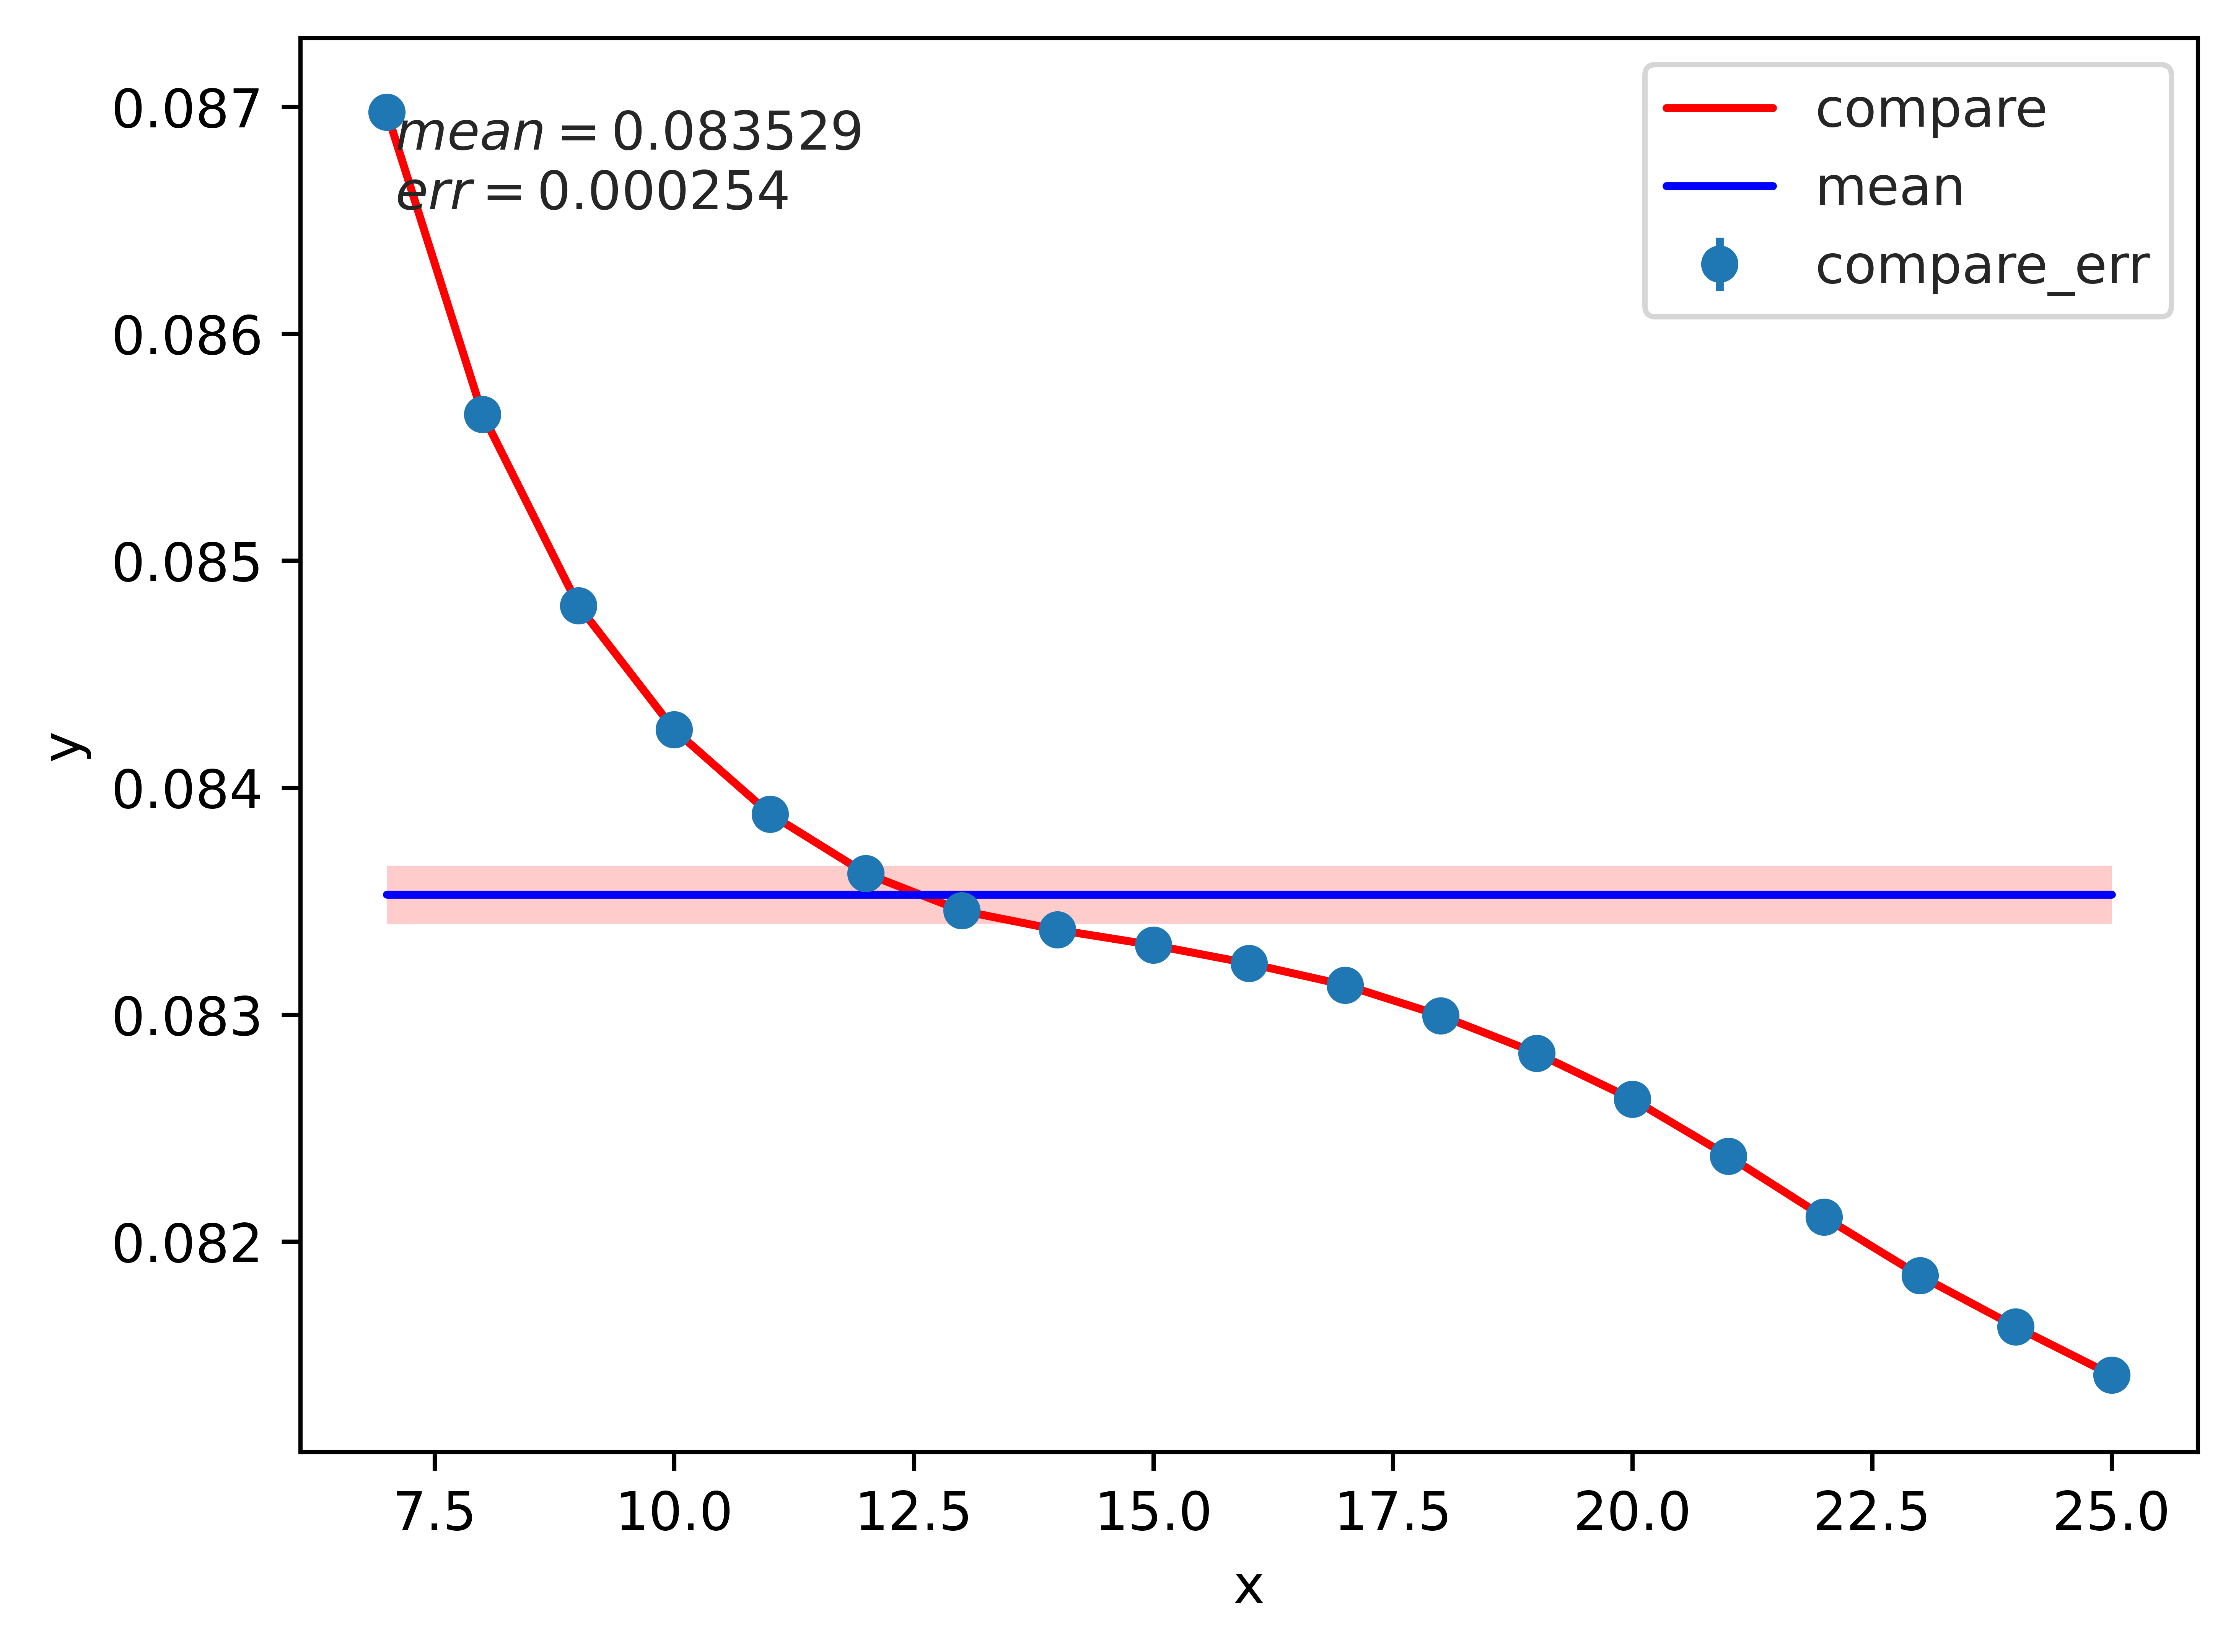

[4.3033990839230325e-05, 4.342257425125795e-05, 4.3996082076626925e-05, 4.4590484681577315e-05, 4.512187290620429e-05, 4.5402331691323947e-05, 4.5485397529905636e-05, 4.558930404430137e-05, 4.561067834091874e-05, 4.561986934306559e-05, 4.591775732063123e-05, 4.6515683361060234e-05, 4.73645920218017e-05, 4.857831591313156e-05, 5.00531549769126e-05, 5.182557661222625e-05, 5.3695909479425825e-05, 5.51410781917605e-05, 5.61774029424859e-05]


In [15]:
main()

# test

In [16]:
# m_list=np.array(m_list)
# jk_m_all=jackknife(m_list)
# jk_m=jk_m_all["mean"]
# jk_m_std=jk_m_all["std"]
# data_name=[int(i["data_name"].unique()) for i in df_list]
# fig, ax = plt.subplots(dpi=1000)
# sns.set_style('whitegrid')
# ax.errorbar(data_name, jk_m, yerr=jk_m_std, fmt='o', label='m')
# # ax.plot(data_name, jk_m, 'r-', label='Fit')
# ax.set_xlabel('data_name')
# ax.set_ylabel('jk_m')
# ax.legend(loc='best')
# textstr = '\n'.join((
#         r'$m_{mean}=%f$' % (np.mean(jk_m),),
#         r'$m_{std}=%f$' % (jk_m_std.unique(),),
#         ))
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top')
# plt.show()
# print(np.mean(m_list),np.std(m_list))


In [17]:
# def model_func(x, a, b):
#     return a * (np.exp(-b * x) + np.exp(-b * (64 - x)))


# x = np.linspace(0, 4, 50)
# y = model_func(x, 2.5, 1.3) + np.random.normal(0, 0.1, len(x))
# yerr = np.ones_like(y) * 0.1
# popt, pcov, perr, chi2_dof, logGBF = nonlinear_fit(x, y, yerr, model_func)
# print(popt, pcov, perr, chi2_dof, logGBF)
# plot_fit(x, y, yerr, model_func, popt, pcov, perr, chi2_dof, logGBF)


In [18]:
# def model_func(x, a, b):
#     return a * (np.exp(-b * x) + np.exp(-b * (64 - x)))


# T_start = 2
# T_end = 19
# small_time = 100000.0
# chi2_dof_list=[]
# for j in range(1,33):
#     for k in range(1,33):
#         T_start = j
#         T_end = k
#         if(j>=k):
#             continue
#         for i in range(len(df_list)):
#             x = np.linspace(start=T_start, stop=T_end, num=T_end - T_start + 1, dtype="int")
#             y = np.array([i["jk_real"].values for i in df_list])[:, x - 1][i] / small_time
#             yerr = np.array([i["jk_real_std"].values for i in df_list])[:, x - 1][i] / small_time
#             popt, pcov, perr, chi2_dof, logGBF = nonlinear_fit(x, y, yerr, model_func)
#             chi2_dof_list.append([j,k,chi2_dof])
# # 2,19
# # print(popt, pcov, perr, chi2_dof, logGBF )
# # plot_fit(x, y, yerr, model_func, popt, pcov, perr, chi2_dof, log


In [19]:
# np.set_printoptions(threshold=np.inf)
# chi2_dof_list=np.array(chi2_dof_list)
# d0=pd.DataFrame(chi2_dof_list)
# d0.to_csv('chi2_dof_list.csv')


In [20]:
# for i in chi2_dof_list:
#     print(i)

# import numpy as np

# def find_nearest(array, value):
#     """
#     Find the element in the array that is closest to the given value.
#     """
#     idx = (np.abs(array - value)).argmin()
#     return array[idx]
# find_nearest(np.array([i[2] for i in chi2_dof_list]),1)
# s=np.abs(np.array([i[2] for i in chi2_dof_list])-1)
# print(chi2_dof_list[s.argmin()])
# print(s.argmin())
# print(s.argmin())


In [21]:
# import numpy as np
# from scipy.optimize import curve_fit

# def fit_function(x, a, b, c):
#     return a * np.exp(-b * x) + c

# def generate_data(a, b, c, x, yerr):
#     return fit_function(x, a, b, c) + np.random.normal(scale=yerr)

# def fit_data(xdata, ydata, yerr):
#     popt, pcov = curve_fit(fit_function, xdata, ydata, sigma=yerr, absolute_sigma=True)
#     perr = np.sqrt(np.diag(pcov))
#     residuals = ydata - fit_function(xdata, *popt)
#     chi2 = np.sum((residuals / yerr)**2)
#     dof = len(ydata) - len(popt)
#     logGBF = -0.5 * chi2 + 0.5 * np.log(np.linalg.det(pcov)) - dof * np.log(len(ydata))
#     return popt, perr, logGBF

# # Generate example data
# n_samples = 10
# n_points = 100
# x = np.linspace(0, 10, n_points)
# a_true, b_true, c_true = 2.5, 1.3, 0.5
# yerr = 0.1 * np.ones(n_points)

# xdata = np.tile(x, (n_samples, 1))
# ydata = np.zeros((n_samples, n_points))

# for i in range(n_samples):
#     ydata[i] = generate_data(a_true, b_true, c_true, x, yerr)

# # Generate covariance matrix
# cov_matrix = np.cov(ydata, rowvar=False)

# # Generate correlated errors
# correlated_errors = np.zeros((n_samples, n_points))

# for i in range(n_samples):
#     correlated_errors[i] = np.random.multivariate_normal(mean=np.zeros(n_points), cov=cov_matrix)

# # Add correlated errors to data
# ydata_correlated = ydata + correlated_errors
# # ydata_correlated = ydata

# # Fit each set of data with correlated errors
# popt_list = []
# perr_list = []
# logGBF_list = []

# for i in range(n_samples):
#     popt, perr, logGBF = fit_data(xdata[i], ydata_correlated[i], yerr)
#     popt_list.append(popt)
#     perr_list.append(perr)
#     logGBF_list.append(logGBF)

# popt_mean = np.mean(popt_list, axis=0)
# popt_std = np.std(popt_list, axis=0)
# perr_mean = np.mean(perr_list, axis=0)
# perr_std = np.std(perr_list, axis=0)
# logGBF_mean = np.mean(logGBF_list)
# logGBF_std = np.std(logGBF_list)

# print('Fitted parameters:')
# print('a = {:.3f} +/- {:.3f}'.format(popt_mean[0], perr_mean[0]))
# print('b = {:.3f} +/- {:.3f}'.format(popt_mean[1], perr_mean[1]))
# print('c = {:.3f} +/- {:.3f}'.format(popt_mean[2], perr_mean[2]))
# print('\nLogGBF = {:.3f} +/- {:.3f}'.format(logGBF_mean, logGBF_std))


In [22]:
# import numpy as np
# from scipy.optimize import curve_fit

# def fit_function(x, a, b, c):
#     return a * np.exp(-b * x) + c

# def generate_data(a, b, c, x, yerr):
#     return fit_function(x, a, b, c) + np.random.normal(scale=yerr)

# def fit_data(xdata, ydata, yerr):
#     popt, pcov = curve_fit(fit_function, xdata, ydata, sigma=yerr, absolute_sigma=True)
#     perr = np.sqrt(np.diag(pcov))
#     residuals = ydata - fit_function(xdata, *popt)
#     chi2 = np.sum((residuals / yerr)**2)
#     dof = len(ydata) - len(popt)
#     logGBF = -0.5 * chi2 + 0.5 * np.log(np.linalg.det(pcov)) - dof * np.log(len(ydata))
#     return popt, perr, logGBF

# # Generate example data
# n_samples = 10
# n_points = 100
# x = np.linspace(0, 10, n_points)
# a_true, b_true, c_true = 2.5, 1.3, 0.5
# yerr = 0.1 * np.ones(n_points)

# xdata = np.tile(x, (n_samples, 1))
# ydata = np.zeros((n_samples, n_points))

# for i in range(n_samples):
#     ydata[i] = generate_data(a_true, b_true, c_true, x, yerr)

# # Generate covariance matrix
# cov_matrix = np.cov(ydata, rowvar=False)

# # Generate correlated errors
# correlated_errors = np.zeros((n_samples, n_points))

# for i in range(n_samples):
#     correlated_errors[i] = np.random.multivariate_normal(mean=np.zeros(n_points), cov=cov_matrix)

# # Add correlated errors to data
# # ydata_correlated = ydata + correlated_errors
# ydata_correlated = ydata

# # Fit each set of data with correlated errors
# popt_list = []
# perr_list = []
# logGBF_list = []

# for i in range(n_samples):
#     popt, perr, logGBF = fit_data(xdata[i], ydata_correlated[i], yerr)
#     popt_list.append(popt)
#     perr_list.append(perr)
#     logGBF_list.append(logGBF)

# popt_mean = np.mean(popt_list, axis=0)
# popt_std = np.std(popt_list, axis=0)
# perr_mean = np.mean(perr_list, axis=0)
# perr_std = np.std(perr_list, axis=0)
# logGBF_mean = np.mean(logGBF_list)
# logGBF_std = np.std(logGBF_list)

# print('Fitted parameters:')
# print('a = {:.3f} +/- {:.3f}'.format(popt_mean[0], perr_mean[0]))
# print('b = {:.3f} +/- {:.3f}'.format(popt_mean[1], perr_mean[1]))
# print('c = {:.3f} +/- {:.3f}'.format(popt_mean[2], perr_mean[2]))
# print('\nLogGBF = {:.3f} +/- {:.3f}'.format(logGBF_mean, logGBF_std))


In [23]:
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.linspace(0, 2 * np.pi, 100)
# y = np.sin(x)

# fig, ax = plt.subplots()
# ax.plot(x, y, color='black', linewidth=1)

# ax.fill_between(x, y, 0, where=((y > 0)&(y<0.5)), interpolate=True, color='blue', alpha=0.2, linewidth=y)
# # ax.fill_between(x, y, 0, where=(y < 0), interpolate=True, color='red', alpha=0.2, linewidth=-y)

# plt.show()
